<a href="https://colab.research.google.com/github/Desmondmies/Mallory/blob/main/mallory-collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install unidecode



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from unidecode import unidecode

In [ ]:
X = !curl "https://files.vermeille.fr/hp.txt" -o -
X_txt = '\n'.join(X)
print(X_txt[:250])

[]

[cover]

J.K.ROWLING

Harry Potter

à l'Ecole des Sorciers

Traduit de l'anglais

par Jean-François Ménard

[]

GALLIMARD

Rev 2, 16/12/2010

Pour Jessica, qui adore les histoires,

pour Anne, qui les adorait aussi

et pour Di, qui a été la premi


In [ ]:
X = unidecode(X_txt)
X = torch.tensor(list(map(ord, X)), dtype=torch.long)
print(X[:10], len(X)), torch.any(X >= 128)

tensor([ 91,  93,  10,  10,  91,  99, 111, 118, 101, 114]) 7803296


(None, tensor(False))

In [ ]:
# we don't define a testset. The model is wayyy too trivial to overfit.

In [ ]:
class Concat(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

def make_nn(input_features, context_size, hidden_features, output_features):
    return nn.Sequential(
        nn.Embedding(128, input_features),
        Concat(),
        nn.Linear(input_features * context_size, hidden_features),
        nn.ReLU(),
        nn.Linear(hidden_features, hidden_features),
        nn.ReLU(),
        nn.Linear(hidden_features, hidden_features),
        nn.ReLU(),
        nn.Linear(hidden_features, output_features)
    )

batch_size=512
context_size=8
device='cuda'
m = make_nn(32, context_size, 512, 128).to(device)

loss_fn = nn.CrossEntropyLoss()

opt = torch.optim.AdamW(m.parameters(), lr=3e-4, weight_decay=0.01)
losses = []
for epoch in range(500):

    with torch.no_grad():
      print('----')
      for num_completions in range(5):
          s = "\nAujourd'hui"[:context_size]
          for txt_len in range(64):
              as_tensor = torch.tensor(list(map(ord, s[-context_size:]))).cuda()
              logits = m(as_tensor.unsqueeze(0))
              probs = torch.softmax(logits, dim=1)
              new = torch.multinomial(probs, num_samples=1)
              s += chr(new.item())
              del as_tensor
          print(repr(s))

    # we train here
    train_error = 0
    for _ in range(1000):
        letters = torch.stack([
            X[rnd : rnd + context_size + 1]
            for rnd in torch.randint(0, len(X) - context_size - 1, (batch_size,))
        ]).to(device)
        x = letters[:, :-1]
        y = letters[:, -1]

        opt.zero_grad()
        pred = m(x) # [batch, in_features] => [batch, out_features]
        loss = loss_fn(pred, y)
        loss.backward()
        train_error += loss.item()
        opt.step()
    print((epoch+1)*context_size*batch_size, 'k chars | train', train_error / 1000/batch_size)
    losses.append(train_error/1000/batch_size)

    # We test here

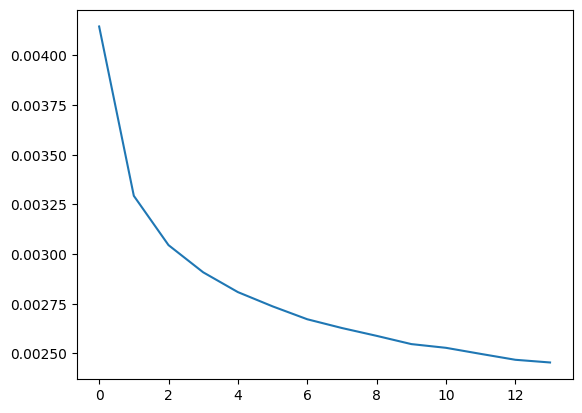

In [ ]:
plt.plot([l for l in losses])
plt.show()